1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train_resampled.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train_resampled.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/test_cleaned.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

2. Random Forest - Feature Importance

In [7]:
# 2.1 Feature Importance Check with basic random forest model
#Import RandomForestClassifier and instantiate the model
from sklearn.ensemble import RandomForestClassifier
rf_1 = RandomForestClassifier(random_state=8,  max_features='sqrt')


rf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [8]:
#Display feature importance
rf_1.feature_importances_

array([0.02530916, 0.0263004 , 0.01689583, 0.01814178, 0.01862598,
       0.0215741 , 0.02092012, 0.01993454, 0.01783661, 0.0192892 ,
       0.01866751, 0.02031441, 0.07444716, 0.04402616, 0.01594507,
       0.10592113, 0.01987721, 0.02142038, 0.01896545, 0.0309966 ,
       0.07776137, 0.05788649, 0.0420906 , 0.02608344, 0.05343847,
       0.02455817, 0.02601657, 0.02596142, 0.02069164, 0.02800486,
       0.04209816])

In [9]:
#Create a new dataframe "feat_imp_et_df" with the features importances and their name
feat_imp_et_df = pd.DataFrame(
    {
    'feature': X_train.columns,
     'feature_importance': rf_1.feature_importances_
     }
)

In [10]:
X_train.columns

Index(['GP', 'usg', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FT_per',
       'twoP_per', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'porpag', 'adjoe',
       'pfr', 'Rec_Rank', 'ast_tov', 'rim_ratio', 'mid_ratio', 'adrtg',
       'dporpag', 'stops', 'bpm', 'dbpm', 'gbpm', 'dgbpm', 'treb', 'ast',
       'stl', 'blk', 'pts'],
      dtype='object')

In [11]:
#Create a bar chart showing the features importance for the random tree model
alt.Chart(feat_imp_et_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance'])

alt.Chart(...)

3. Random Forest - Modelling

In [12]:
#3.1 Import RandomForestClassifier and instantiate the model
from sklearn.ensemble import RandomForestClassifier

rf_3 = RandomForestClassifier(
    n_estimators=200,         
    max_depth=10,              
    min_samples_split=100,     
    min_samples_leaf=10,       
    max_features='sqrt',       
    bootstrap=True,            
    random_state=42
)

In [13]:
# 3.2 Train the model and save the predicted values
rf_3.fit(X_train, y_train)
y_train_probs_rf3 = rf_3.predict_proba(X_train)
y_val_probs_rf3 = rf_3.predict_proba(X_val)

# Select the probability for the positive class (class 1)
y_train_probs_rf3 = y_train_probs_rf3[:, 1]
y_val_probs_rf3 = y_val_probs_rf3[:, 1]

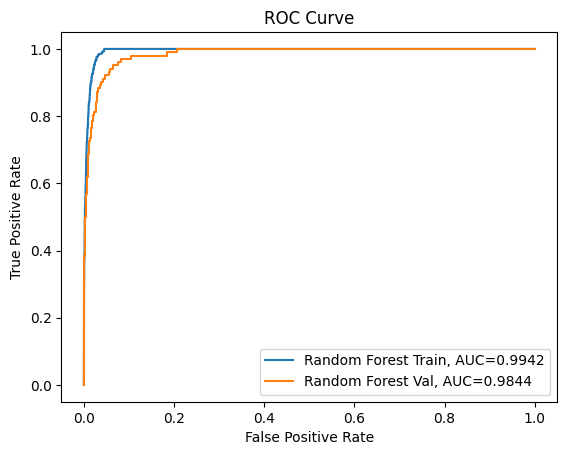

In [14]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric
from sklearn import metrics

# Set up plotting area
plt.figure(0).clf()

# Random Forest - Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_rf3)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_rf3), 4)
plt.plot(fpr, tpr, label="Random Forest Train, AUC="+str(auc))

# Random Forest - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_rf3)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_rf3), 4)
plt.plot(fpr, tpr, label="Random Forest Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [15]:
# 3.4 Save the probability of the test data
y_test_prob_rf3 = rf_3.predict_proba(X_test)

# Select the probability for the positive class (class 1)
y_test_prob_rf3 = y_test_prob_rf3[:, 1]


In [16]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_prob_df = pd.DataFrame(y_test_prob_rf3, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results_1 = pd.concat([player_id_test, y_test_prob_df], axis=1)

In [17]:
Results_1

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,6.844409e-07
1,52a518bb-b34a-4b43-adee-5e996cb853fa,1.905740e-06
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,1.736279e-03
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,2.802473e-05
4,55d07491-5bd1-447f-844e-9cb36eaa442e,2.437390e-03
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,2.027469e-02
4966,c32a466d-7a66-47eb-805c-a94e328261bc,1.502504e-06
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,1.502504e-06
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,1.502504e-06


In [18]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results_1).to_csv('../data/external/smote_RandomForest_Results.csv', index=False)

#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively randomForest.joblib 
dump(rf_3, '../models/randomForest_smote.joblib')


['../models/randomForest_smote.joblib']